In [1]:
# Bibliotecas - Tensorflow, Keras e Sklearn

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten

# Bibliotecas auxiliares

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import splitfolders
import datetime
import pickle
import random
import shutil
import time
import glob
import cv2
import os

# Meus módulos
from cf_matrix import make_confusion_matrix

In [2]:
# Funções para obter data e hora do treinamento

def ObterData():
    return str('{date:%Y%m%d_%H%M}').format(date = datetime.datetime.now())

def ObterTempoExec(inicio, fim):
    return (fim - inicio) / 60

In [3]:
print('\n[INFO] Inicializando script...\n')

print('[INFO] Criando sub-conjuntos de dados...\n')
inicio = time.time()

# Gera a semente aleatória
random_seed = random.randint(1, 1000)

# Splitfolders para separar o conjunto de dados em sub-conjuntos

splitfolders.ratio(input = 'dataset_full', output = 'dataset_split',
                   seed = random_seed, ratio = (0.8, 0.2),
                   group_prefix = None)

fim = time.time()
print('[INFO] Tempo de execução: %.1f min' %(ObterTempoExec(inicio, fim)))


[INFO] Inicializando script...

[INFO] Criando sub-conjuntos de dados...

[INFO] Tempo de execução: 20.7 min


In [4]:
# Variáveis e Diretórios

FILE_NAME = 'rf_model_'
file_date = ObterData()

DATA_TRAIN = 'dataset_split/train' # diretório de treino
DATA_TEST = 'dataset_split/val' # diretório de teste

SIZE = 64 # dimensão da imagem
CHANNEL = 3 # RGB
INPUT_SHAPE = (SIZE, SIZE, CHANNEL) # formato de entrada

CLASSES = ['A','B','C','D','E','F','G','I','L','M','N','O','P','Q','R','S',
           'T','U','V','W','Y'] # classes do conjunto de dados

# LEITURA E PRÉ PROCESSAMENTO DAS IMAGENS

In [5]:
# Listas para receber os valores e os labels

train_images = []
train_labels = []

# Percorre todas as pastas do dir de treino
for directory_path in glob.glob(DATA_TRAIN + "/*"):
    
    # Atribui o rótulo da pasta a label
    label = directory_path.split("\\")[-1]
    print(label)
    
    # Percorre todos os arquivos das pastas do dir de treino
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        
        # Lê a imagem, redimensiona e insere na lista
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        
        train_images.append(img)
        train_labels.append(label)
        
# Transforma as listas em matrizes numpy
train_images = np.array(train_images)
train_labels = np.array(train_labels)

A
B
C
D
E
F
G
I
L
M
N
O
P
Q
R
S
T
U
V
W
Y


In [6]:
# obs: mesmo processo do trecho acima, porém com o conjunto de teste

test_images = []
test_labels = []

for directory_path in glob.glob(DATA_TEST + "/*"):
    
    sign_label = directory_path.split("\\")[-1]
    print(sign_label)
    
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        
        test_images.append(img)
        test_labels.append(sign_label)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

A
B
C
D
E
F
G
I
L
M
N
O
P
Q
R
S
T
U
V
W
Y


In [7]:
# Transforma os rótulos de texto para o formato numérico

label_to_id = {v:i for i,v in enumerate(np.unique(train_labels))}
id_to_label = {v: k for k, v in label_to_id.items()}

train_labels_ids = np.array([label_to_id[x] for x in train_labels])
test_labels_ids = np.array([label_to_id[x] for x in test_labels])

In [8]:
# atribuo os dados em dois conjuntos para treino e teste

X_train, y_train, X_test, y_test = train_images, train_labels_ids, test_images, test_labels_ids

In [9]:
# Limpa as variáveis

train_images = None
test_images = None

In [10]:
# normaliza/rescala os pixels que estão com valores entre 0 a 255 para 0 a 1

X_train, X_test = X_train / 255.0, X_test / 255.0

# EXTRATOR DE RECURSOS

In [11]:
extractor = Sequential()

extractor.add(Conv2D(8, 3, padding='same', input_shape = (SIZE,SIZE,3), activation='relu'))
extractor.add(MaxPool2D(pool_size = (2,2)))

extractor.add(Conv2D(16, 3, padding='same', activation='relu'))
extractor.add(MaxPool2D(pool_size = (2,2)))

extractor.add(Conv2D(32, 3, padding='same', activation='relu'))
extractor.add(MaxPool2D(pool_size = (2,2)))

extractor.add(Flatten())

In [12]:
extractor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 8)         224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

In [13]:
# Captura os recuros gerados através da camada de flatten (onde os valores estão achatados em um vetor)
# Que é a saída do nosso extrator

layer_name = 'flatten'
flatten_layer = Model(inputs = extractor.input, outputs = extractor.get_layer(layer_name).output)

In [14]:
# Extraindo os recursos de cada imagem do treino através do nosso extrator
# A quantidade de recursos na flatten determina a quantidade de recursos para cada imagem

i = 0
features = np.zeros(shape = (X_train.shape[0], 2048))

for directory_path in glob.glob(DATA_TRAIN + "/*"):
    
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)    
        img = cv2.resize(img, (SIZE, SIZE))
        
        img = np.expand_dims(img, axis = 0)
        flatten_output = flatten_layer.predict(img)
        features[i] = flatten_output
        
        i += 1

In [15]:
# Nomeia as linhas como recursos -> f_0, f_1, f_2 . . .

feature_col = []

for i in range(2048):
    feature_col.append("f_"+str(i))
    i += 1

In [16]:
# Cria um Dataframe com os nomes e valores dos recursos 

train_features = pd.DataFrame(data = features, columns = feature_col)
feature_col = np.array(feature_col)

train_class = list(np.unique(train_labels_ids))

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels_ids.shape)

train_class

Training Features Shape: (37008, 2048)
Training Labels Shape: (37008,)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [17]:
train_features.head()

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_2038,f_2039,f_2040,f_2041,f_2042,f_2043,f_2044,f_2045,f_2046,f_2047
0,11.613594,4.396462,0.0,25.035751,26.577129,27.229969,8.395553,9.356200,28.778156,5.921926,...,0.0,1.253208,14.059825,0.0,14.752256,5.454573,26.435343,5.592546,15.780231,12.306380
1,11.642136,4.106272,0.0,25.204800,27.209068,28.274387,8.402514,9.879939,30.517548,7.119217,...,0.0,1.390683,14.553936,0.0,15.014150,5.234823,27.084949,5.309928,15.758938,12.708414
2,17.810658,5.958069,0.0,40.017033,43.864449,45.289009,14.110189,15.668675,46.949932,11.084447,...,0.0,3.013096,43.117348,0.0,34.823261,9.921666,59.798401,12.350441,32.996780,30.229370
3,18.078165,5.824572,0.0,40.199783,43.754890,45.480034,14.225178,15.463298,46.928883,10.983285,...,0.0,3.016919,41.767517,0.0,34.805187,9.815576,60.993202,12.238617,33.619114,30.338818
4,18.095596,5.873848,0.0,40.167683,43.649593,45.564804,14.340168,15.632047,46.967804,11.242489,...,0.0,4.711346,35.962902,0.0,33.867073,9.629003,59.415428,12.586864,34.647114,30.115541


In [18]:
# Mesmo processo de extração de recuros usado no treino, porém aqui com os dados de teste

i = 0
features_test=np.zeros(shape=(y_test.shape[0], 2048))

for directory_path in glob.glob(DATA_TEST + "/*"):
        
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)    
        img = cv2.resize(img, (SIZE, SIZE))
        
        img = np.expand_dims(img, axis=0)
        flatten_output = flatten_layer.predict(img)
        features_test[i]= flatten_output
        
        i+=1

In [19]:
# Cria um Dataframe com os nomes e valores dos recursos

test_features = pd.DataFrame(data=features_test, columns=feature_col)
feature_col = np.array(feature_col)

print('Test Features Shape:', test_features.shape)
print('Test Labels Shape:', test_labels_ids.shape)

Test Features Shape: (9254, 2048)
Test Labels Shape: (9254,)


In [20]:
test_features.head()

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_2038,f_2039,f_2040,f_2041,f_2042,f_2043,f_2044,f_2045,f_2046,f_2047
0,15.953975,4.325819,0.0,35.850662,39.632027,42.640491,13.088956,14.119717,42.411888,10.981654,...,0.0,2.117057,28.557211,0.0,29.984564,11.943789,52.211422,10.922163,31.632624,26.586966
1,18.205353,6.116775,0.0,40.396439,43.992374,45.192017,14.404650,15.747183,47.061623,10.973241,...,0.0,5.496141,36.379410,0.0,32.546253,9.648134,60.860287,16.009089,37.023548,30.212204
2,18.010345,5.935387,0.0,40.282703,43.734982,45.559017,14.409931,15.569498,46.915134,11.061447,...,0.0,5.614117,36.010101,0.0,32.732544,10.246421,61.156475,14.497836,36.079380,30.095583
3,18.274439,5.822301,0.0,40.164532,43.775158,45.623516,14.584169,15.826113,46.964966,11.034492,...,0.0,5.574103,34.677971,0.0,32.775970,10.414117,60.420364,12.945090,35.269005,30.395744
4,18.118153,5.936803,0.0,40.235889,43.949863,45.373058,14.459060,15.777263,47.018044,11.126542,...,0.0,5.185746,35.099644,0.0,33.062218,9.569876,59.941704,12.687011,35.230537,30.252035


# TREINAMENTO DO RANDOM FOREST 

In [21]:
# Agora que temos os recursos, podemos treinar o RF para aprender com os recursos extraídos do conjunto de treino

# RANDOM FOREST FOR CLASSIFIER

print('\n[INFO] treinando o modelo...\n')
inicio = time.time()

rf_model = RandomForestClassifier(n_estimators = 50, max_depth=9, criterion='entropy', min_samples_split=2,
                                  min_samples_leaf=1, max_features='auto', bootstrap=True)

# Passamos o dataframe com os recursos e os rótulos do conjunto de treino

rf_model.fit(train_features, train_labels_ids)

fim = time.time()
print('[INFO] tempo de execução do modelo: %.1f min' %(ObterTempoExec(inicio, fim))+'\n')

# Para fazer a predição preciso do train_features e train_labels_ids (rótulos do treino)

result_prediction = rf_model.predict(train_features)

accuracy=accuracy_score(result_prediction , train_labels_ids)
print('Accuracy:', accuracy*100, '%.')


[INFO] treinando o modelo...

[INFO] tempo de execução do modelo: 2.9 min

Accuracy: 97.5383700821444 %.


In [22]:
# para fazer a predição do test depois de carregar o modelo, preciso do test_features e test_labels_ids (rótulos do teste)

result_prediction_test = rf_model.predict(test_features)

accuracy=accuracy_score(result_prediction_test , test_labels_ids)
print('Accuracy:', accuracy*100, '%.')

Accuracy: 95.68835098335855 %.


## 1 - tempo: 3.1 min / acc_train: 97.42% / acc_test: 96.72%

## 2-  tempo: 2.8 min / acc_train: 97.34% / acc_test: 96.06%

## 3 - tempo: 3.4 min / acc_train: 97.47% / acc_test: 96.33%

## 4 - tempo: 3.2 min / acc_train: 97.65% / acc_test: 96.35%

## 5 - tempo: 3.4 min / acc_train: 97.53% / acc_test: 96.61%

## 6 - tempo: 2.5 min / acc_train: 97.48% / acc_test: 96.43%

## 7 - tempo: 2.7 min / acc_train: 98.04% / acc_test: 96.46%

## 8 - tempo: 3.4 min / acc_train: 97.76% / acc_test: 96.73%

## 9 - tempo: 3.6 min / acc_train: 97.96% / acc_test: 97.01%

## 10 - tempo: 2.9 min / acc_train: 97.53% / acc_test: 95.68%

# MATRIZ DE CONFUSÃO

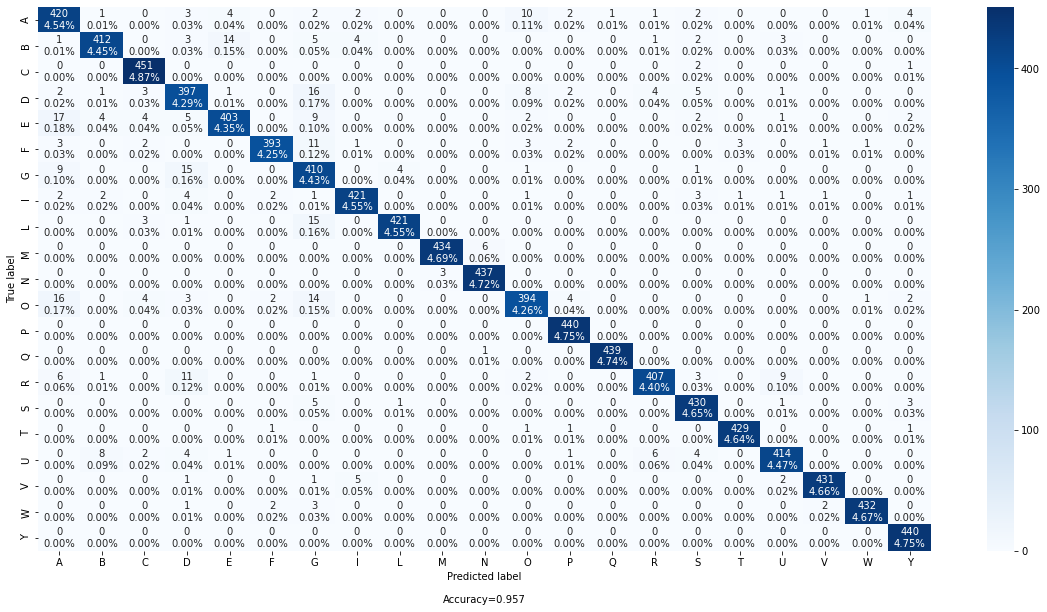

In [23]:
# gerando matriz de confusão para verificar precisão por classe

CLASSES = ['A','B','C','D','E','F','G','I','L','M','N','O','P','Q','R','S','T','U','V','W','Y']

cm = confusion_matrix(test_labels_ids, result_prediction_test)
make_confusion_matrix(cm, figsize = (20,10), categories = CLASSES)

plt.savefig('outputs/confusion_matrix/' + FILE_NAME + file_date + '.png', transparent=True)

# RELATÓRIO DE CLASSIFICAÇÃO COM YELLOWBRICK 

C:\Users\junio\anaconda3\envs\machinelearning\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


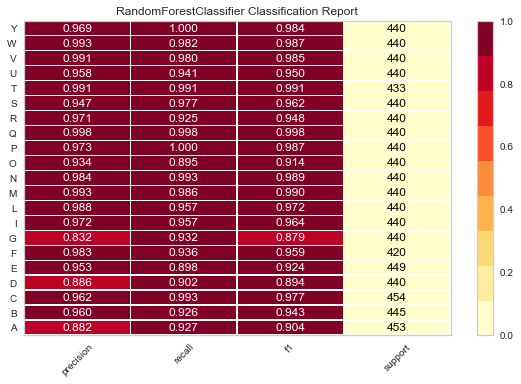

<AxesSubplot:title={'center':'RandomForestClassifier Classification Report'}>

In [24]:
from yellowbrick.classifier import ClassificationReport

visualizer = ClassificationReport(rf_model, classes=CLASSES, support=True)

visualizer.score(test_features, test_labels_ids)
visualizer.show()                   

# SALVANDO O MODELO TREINADO DO RF

In [25]:
import pickle

FILE_NAME = 'rf_libras_'

pickle.dump(rf_model, open('outputs/trained_models/' + FILE_NAME + file_date + '.pickle', 'wb'))

In [26]:
# Limpando sub-conjuntos criados

dirPath = 'dataset_split'

try:
    print('[INFO] Apagando sub-conjuntos criados...\n')
    shutil.rmtree(dirPath)
    
except OSError as e:
    print(f"Error:{ e.strerror}")

[INFO] Apagando sub-conjuntos criados...

